[Hands on RL Policy Gradient](https://github.com/PacktPublishing/Hands-on-Reinforcement-Learning-with-PyTorch/blob/master/Section%204/4.3%20Policy%20Gradients%20REINFORCE.ipynb)

[Policy Gradient Math](https://towardsdatascience.com/policy-gradients-in-reinforcement-learning-explained-ecec7df94245)

A widely used variation of REINFORCE is to subtract a baseline value from the return to reduce the variance of gradient estimation while keeping the bias unchanged (Remember we always want to do this when possible). For example, a common baseline is to subtract state-value from action-value, and if applied, we would use advantage:

$$
A(s,a) = Q(s,a) - V(s)
$$

in the gradient ascent update. This [post](https://danieltakeshi.github.io/2017/03/28/going-deeper-into-reinforcement-learning-fundamentals-of-policy-gradients/) nicely explained why a baseline works for reducing the variance, in addition to a set of fundamentals of policy gradient.

In [1]:
!pip install swig
!pip install gymnasium[box2d]

In [2]:
import torch
from torch import cuda, device, distributions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torch.distributions import Categorical
import math

import gymnasium as gym
import os, random
from pathlib import Path
from collections import deque

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [3]:
env_id = "LunarLander-v2"
env = gym.make(env_id)#,render_mode="human")

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  8
Sample observation [ 0.992328    0.32979658 -4.309148   -1.3564862  -1.1549742   0.49793294
  0.16776827  0.54310155]


In [4]:
device = device("cuda:0" if cuda.is_available() else "cpu")

In [5]:
def calc_disc_return(r_t , gamma = 0.998):

    G_t = deque(maxlen = len(r_t))
    G_t.append(r_t[-1])

    for i in reversed(r_t[:-1]):
        disc = i + (gamma*G_t[0])
        G_t.appendleft(disc)

    return np.array(G_t)

class PolicyNet(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(PolicyNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return F.softmax(self.output(x),dim = 1)

class ValueFunctionNet(nn.Module):
    def __init__(self, state_size, hidden_size):
        super(ValueFunctionNet, self).__init__()
        self.dense_layer_1 = nn.Linear(state_size, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.clamp(x,-1.1,1.1)
        x = F.relu(self.dense_layer_1(x))
        x = F.relu(self.dense_layer_2(x))
        return self.output(x)

The learning rate of the advantage network (also known as the value network) can vary depending on the specific implementation, architecture, and problem domain. However, typically it is chosen to be smaller than the learning rate of the policy network.

The reason for this is that the advantage network is used to estimate the advantage or the baseline, which is then subtracted from the rewards to reduce variance. Since this network is indirectly influencing the updates to the policy network, having a lower learning rate can help stabilize training and prevent overshooting or divergence.

In [6]:
hidden_layer = 64
gamma = 0.99
policy_lr = 0.001
value_lr = 0.0001

policy_net = PolicyNet(s_size, a_size, hidden_layer).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr = policy_lr)

value_net = ValueFunctionNet(s_size, hidden_layer).to(device)
val_optimizer = optim.Adam(value_net.parameters(), lr = value_lr)

In [7]:
epi_results = []
loss_logger = []

for epi in range(100_000):

    s = env.reset()[0]
    term , trunc = False, False
    rewards, states , actions = [], [], []
    win = 0

    while not any([term, trunc]):

        states.append(s)
        obs = torch.FloatTensor(np.expand_dims(s,0)).to(device)

        with torch.no_grad():
            p_vals = policy_net(obs)
            p_vals = torch.squeeze(p_vals)

        p_vals = p_vals.detach().cpu().numpy()
        a = np.random.choice(a_size, p=p_vals)

        s_, r, term ,trunc, _  = env.step(a)
        actions.append(a)
        rewards.append(r)
        s=np.copy(s_)

    state_t = torch.FloatTensor(states).to(device)
    action_t = torch.LongTensor(actions).to(device).view(-1,1)
    return_t = torch.FloatTensor(calc_disc_return(rewards, gamma)).to(device).view(-1,1)

    vf_t = value_net(state_t).to(device)
    with torch.no_grad():
        advantage_t = return_t - vf_t

    selected_action_prob = policy_net(state_t).gather(1, action_t)
    loss = torch.mean(-torch.log(selected_action_prob) * advantage_t)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_fn = nn.MSELoss()
    vf_loss = loss_fn(vf_t, return_t)
    val_optimizer.zero_grad()
    vf_loss.backward()
    val_optimizer.step()

    epi_results.append(np.sum(rewards))
    loss_logger.append(loss.item())

    if epi%100==0:
        clear_output()
    if epi%10==0:
        print(f'epi:{epi:05d} reward:{np.sum(rewards):8.2f} loss:{loss:8.2f}')
    if np.mean(epi_results[-50:])>200:
        break

epi:07100 reward:  220.20 loss:   23.70
epi:07110 reward:  213.12 loss:   25.72
epi:07120 reward:  230.10 loss:   19.36
epi:07130 reward:   91.68 loss:   -5.01
epi:07140 reward:  233.73 loss:    5.83
epi:07150 reward:  234.13 loss:    1.10
epi:07160 reward:  267.99 loss:   27.12


This technique to log grads is the book Deep Re-inforcement Learning.pdf chapter 12 page 313

<a href = "D:\\D Drive\\Docs\\Python\\Deep Re-inforcement Learning.pdf"> ref. </a>

In [14]:
grads = np.concatenate([p.grad.data.detach().cpu().numpy().flatten()
for p in policy_net.parameters()
if p.grad is not None])

In [15]:
g_l2 = np.sqrt(np.mean(np.square(grads)))
g_max = np.max(np.abs(grads))

In [16]:
g_l2

0.43779832

In [8]:
#smoothed = np.convolve(np.array(epi_results), np.ones(50)/50)
mean_results = [np.mean(epi_results[i:i+50]) for i in range(epi-49)]

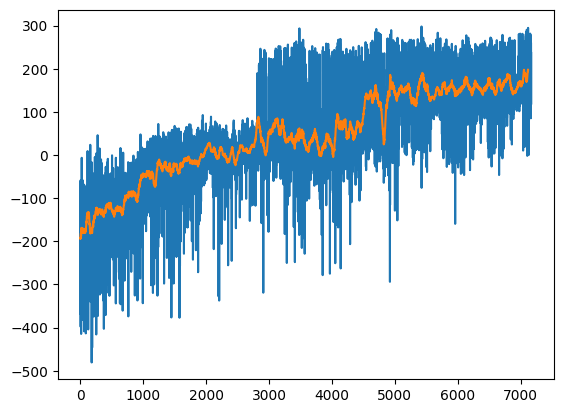

In [9]:
plt.plot(epi_results)
plt.plot(mean_results)

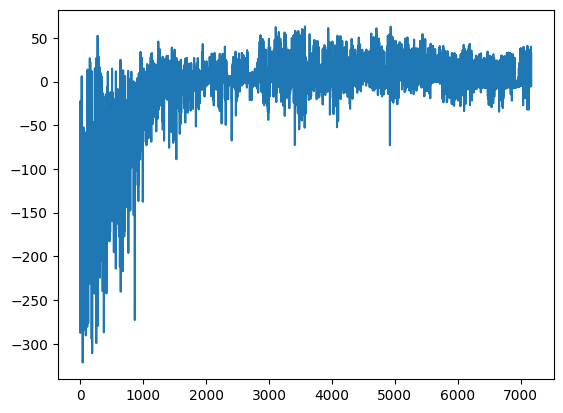

In [10]:
plt.plot(loss_logger)

In [11]:
eval_env = gym.make(env_id,render_mode="human")

for epi in range(10):

    s = eval_env.reset()[0]
    term = False
    trunc = False
    score = 0
    n=0
    while not any([term, trunc]):

        obs = torch.FloatTensor(np.expand_dims(s,0)).to(device)

        with torch.no_grad():
            p_vals = policy_net(obs)
            p_vals = torch.squeeze(p_vals)

        p_vals = p_vals.detach().cpu().numpy()
        #a = np.random.choice(a_size, p=p_vals)
        a = np.argmax(p_vals)
        s, r, term ,trunc , _  = eval_env.step(a)
        #s = np.copy(s_)
        #env.render()
        n+=1
        score+=r

    print(f'{epi = } result {score:4.2f}')
eval_env.close()

epi = 0 result 248.90
epi = 1 result 68.86
epi = 2 result 248.65
epi = 3 result 250.87
epi = 4 result 244.88
epi = 5 result 204.12
epi = 6 result 249.06
epi = 7 result 196.40
epi = 8 result 254.38
epi = 9 result 265.77
